## Krusell Smith Model

Here, I solve an example Krusell-Smith model using my toolkit. The model is standard with code in [krusell_smith.py](models/krusell_smith.py).

#### Config

In [14]:
from models.krusell_smith import KrusellSmith  # model code
import matplotlib.pyplot as plt  # plot things
from toolkit.estimation import *  # estimation
from toolkit.irfs import single_shock_irfs  # impulse responses
import pandas as pd  # data things
import numpy as np  # matrix/vector things

#### Steady State
Using the EGM, solve for the steady state of the model.

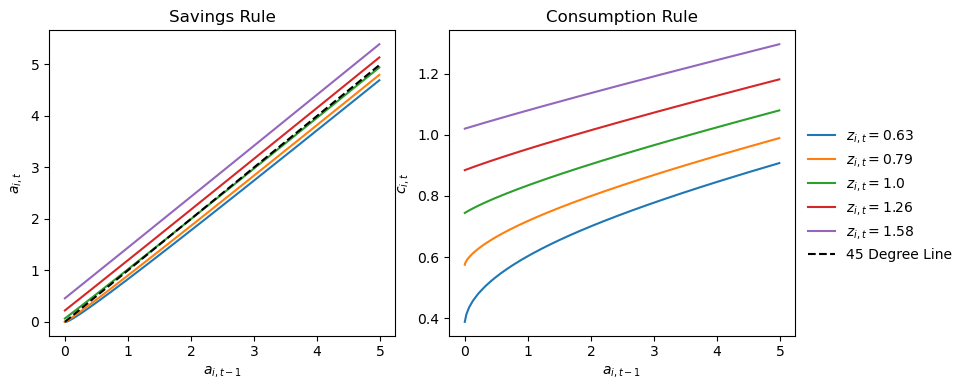

In [2]:
## intialize model
mod_pars = {
        'beta': 0.95, 'gamma': 2., 'delta': 0.05,  # household parameters
        'N_z': 5, 'rho_z': 0.9, 'sigma_z': 0.1,  # household state transitions
        'alpha': 0.3,  # govt parameters
        'A': 1., 'g': 0.2,  # shock steady state
        'N_a': 501, 'a_min': 0, 'a_max': 500,  # grid states
    }
ks = KrusellSmith(**mod_pars)

## solve steady state
free = ['K']
endog = ['Y', 'W', 'R', 'G', 'tau']
V_a0 = (ks.a_grid[:, None] * (1 / ks.beta - 1) + ks.z_grid)**(-ks.gamma)
X0 = np.array([5.])
ks.solve_ss(free, endog, V_a0, X0)
assert np.isclose(ks.curlC + ks.K * ks.delta + ks.G - ks.Y, 0)  # walras

## plot policy functions
# setup plot
fig, axs = plt.subplots(1, 2)
fig.set_figheight(4)
fig.set_figwidth(10)
max_plotted_a = 5  # all the interesting things happen at the start, only plot a < this
n_gps = (ks.a_grid <= max_plotted_a).sum()  # number of gridpoints we plot
axs[0].set_title('Savings Rule')
axs[0].set_xlabel('$a_{i, t-1}$')
axs[0].set_ylabel('$a_{i, t}$')
axs[1].set_title('Consumption Rule')
axs[1].set_xlabel('$a_{i, t-1}$')
axs[1].set_ylabel('$c_{i, t}$')

# savings rule
axs[0].plot(ks.a_grid[:n_gps], ks.a[:n_gps], label=['$z_{i, t}='+str(round(z, 2))+'$' for z in ks.z_grid])
axs[0].plot([0, ks.a_grid[n_gps - 1]], [0, ks.a_grid[n_gps - 1]], 'k--', label='45 Degree Line')

# consumoption rule
axs[1].plot(ks.a_grid[:n_gps], ks.c[:n_gps])

# final things
fig.tight_layout()
fig.subplots_adjust(right=8/10)
fig.legend(loc='center left', bbox_to_anchor=(8/10, 0.5), frameon=False)

#### Shocks
We can also shock the model and look at IRFs.

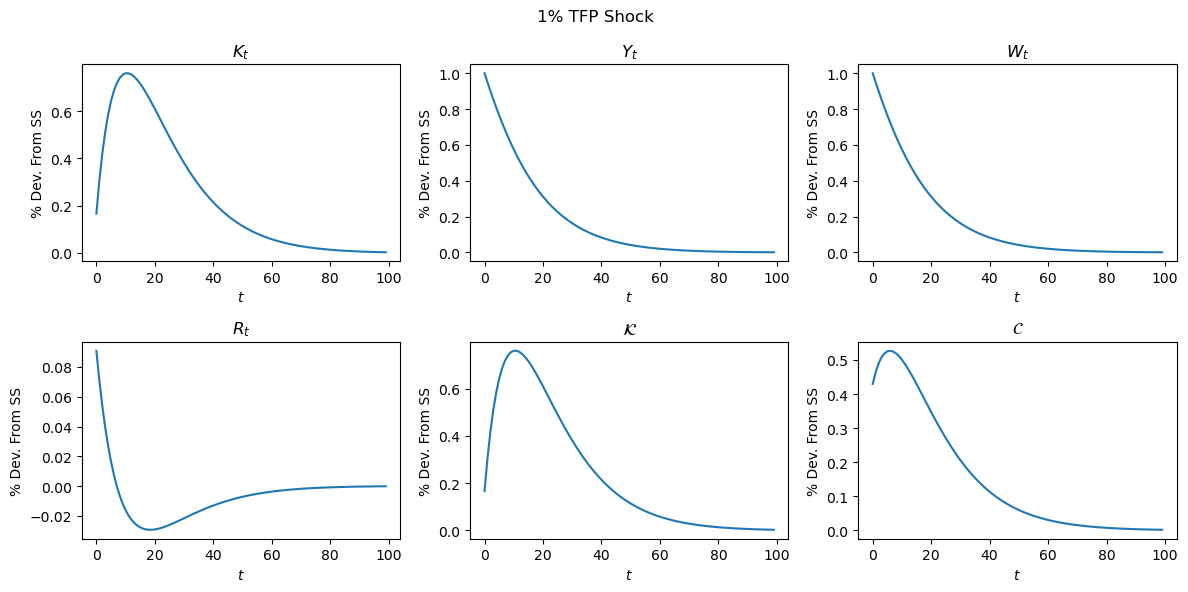

In [3]:
# solve for perturbation matrix
T = 300
G, dxs = ks.solve_G(T, ha=True)  # ha=True is used later to look at policy function responses

# config
vars = ['K', 'Y', 'W', 'R', 'curlK', 'curlC']  # variables we're interested in
labels = {'K': '$K_t$', 'Y': '$Y_t$', 'W': '$W_t$', 'R': '$R_t$', 'curlK': r'$\mathcal{K}$', 'curlC': r'$\mathcal{C}$'}
n = 100  # number of periods we plot

# get irfs
irfs = single_shock_irfs(G['A'], 0.9, T)[0]

# plot config
fig, axs = plt.subplots(2, 3)
fig.set_figwidth(12)
fig.set_figheight(6)
fig.suptitle('1% TFP Shock')

# plot irfs
for i in range(6):
    # variables for i
    v = vars[i]
    ax = axs.take(i)

    # plot it
    ax.set_title(labels[v])
    ax.set_xlabel('$t$')
    ax.set_ylabel('% Dev. From SS')
    ax.plot(irfs[v][:n] / ks.__getattribute__(v))

# final things
fig.tight_layout()

#### Decomposition
We can decompose the shock into the different transmission channels.

In [4]:
# #$ uses the G solved for in the last block
# # setup
# vars = ['K', 'Y', 'W', 'R', 'curlK', 'curlC']  # variables we're interested in
# labels = {'K': '$K_t$', 'Y': '$Y_t$', 'W': '$W_t$', 'R': '$R_t$', 'curlK': r'$\mathcal{K}$', 'curlC': r'$\mathcal{C}$', 'A': '$A$'}
# n = 100  # number of periods we plot

# # get irfs
# irfs, exog_irf = single_shock_irfs(G['A'], 0.9, T)
# decomp = decompose_single_shock_irfs(G['A'], ks.int_block_jacs, exog_irf, 'A')

# # plot config
# fig, axs = plt.subplots(2, 3)
# fig.set_figwidth(12)
# fig.set_figheight(6)
# fig.suptitle('1% TFP Shock')

# # plot irfs
# for i in range(6):
#     # variables for i
#     v = vars[i]
#     ax = axs.take(i)

#     # plot irf
#     ax.set_title(labels[v])
#     ax.set_xlabel('$t$')
#     ax.set_ylabel('% Dev. From SS')
#     ax.plot(irfs[v][:n] / ks.__getattribute__(v), label='Aggregate Effects')

#     # decomposition
#     if v not in decomp.keys():
#         continue
#     for v2, irf in decomp[v].items():
#         ax.plot(irf[:n], label=f'{labels[v2]} Effects')

#     # legend
#     ax.legend()

# # final things
# fig.tight_layout()

#### Policy Functions
We can also look at how policy functions shift post-shock.

In [5]:
# ## uses G from above
# # setup
# var = 'c'
# labels = {'K': '$K_t$', 'Y': '$Y_t$', 'W': '$W_t$', 'R': '$R_t$', 'curlK': r'$\mathcal{K}$', 'curlC': r'$\mathcal{C}$', 'A': '$A$'}
# ts = [0, 25, 50]
# n = (ks.a_grid < 5).sum()  # number of gridpoints we plot

# # get irfs
# _, exog_irf = single_shock_irfs(G['A'], 0.9, T)
# pol_irf = policy_irf(dxs[var], G['A'], exog_irf, 'A')
# pol_decomp = decompose_policy_irf(dxs[var], G['A'], exog_irf, 'A')

# # plot config
# fig, axs = plt.subplots(3, 3)
# fig.set_figwidth(12)
# fig.set_figheight(8)
# fig.suptitle(f'1% TFP Shock, HH ${var}$ Response')
# fig.supxlabel('$a$')
# fig.supylabel('% Dev From SS')

# # plot irfs
# for i in range(3):
#     # variables for i
#     t = ts[i]
#     # ax = axs.take(i)

#     # plot irf
#     axs[0, i].set_title(f'$t = {t}$')
#     axs[0, i].plot(ks.a_grid[:n], pol_irf[t, :n] / ks.__getattribute__(var)[:n])

#     # decomposition
#     axs[1, i].set_title('$W$ Effects')
#     axs[1, i].plot(ks.a_grid[:n], pol_decomp['W'][t, :n] / ks.__getattribute__(var)[:n])
#     axs[2, i].set_title('$R$ Effects')
#     axs[2, i].plot(ks.a_grid[:n], pol_decomp['R'][t, :n] / ks.__getattribute__(var)[:n])

# # final things
# fig.tight_layout()

In [6]:
## read data, creates in make_data.ipynb
df = pd.read_csv('data/data.csv')

# make it levels of model values
df['Y'] *= ks.Y
df['C'] *= ks.curlC
df['W'] *= ks.W
df['N'] *= ks.L
df['G'] *= ks.G

In [7]:
## Setup
outputs = np.array(['Y', 'G'])  # outputs we estimate off of
est_outputs = np.where(outputs == 'curlC', 'C', outputs)  # rename 'curlC' to align with data df
priors = (
        [lambda x: log_beta(x, 0.5, 0.15) for _ in range(2)]  # ar1 coeffs
        + [lambda x: log_inv_gamma(x, 0.4, 4) for _ in range(2)]  # standard deviations
    )
est_G = estimation_G(G, outputs=outputs)  # make the G matric used in estimation, just concatenated version of G
drawf = gen_posterior_prob(est_G, df[np.where(outputs == 'curlC', 'C', outputs)].values, priors)  # evaluate log-liklihood

## posterior mode
res = posterior_mode(drawf, 2, X0=np.hstack((0.5 * np.ones(2), 0.5 * np.ones(2))), tol=0.001)
assert res.success
mode = res.x  # get the mode values
invH = get_invhessian(drawf, mode)  # used to make draws in MCMC

In [8]:
## MCMC
bounds = np.array([(0, 1) for _ in range(2)] + [(0, np.inf) for _ in range(2)]).T
N_sim = 2500  # takes ~3 min per 10k
N_burn = 500
np.random.seed(0)
sim_res, logposterior, accept_rate = metropolis_hastings(drawf, mode, invH, bounds, N_sim, N_burn)
print(f'Accept Rate: {accept_rate * 100:.2f}%')

## get results
means = np.mean(sim_res[N_burn:], axis=0)  # mean
conf_int = np.percentile(sim_res[N_burn:], [5, 95], axis=0)  # confidence interval

# ## collect results
# res_df = pd.DataFrame(
#         data=np.vstack((mode, means, conf_int)).T[[0, 6, 1, 7, 2, 8, 3, 9, 4, 10, 5, 11]],
#         columns=['mode', 'mean', '5%', '95%'],
#         index=np.ravel([(f'rho_{s}', f'sigma_{s}') for s in hank.shocks]),
#     )
# # res_df.to_csv('data/bayes_results.csv')
# res_df

Accept Rate: 51.32%


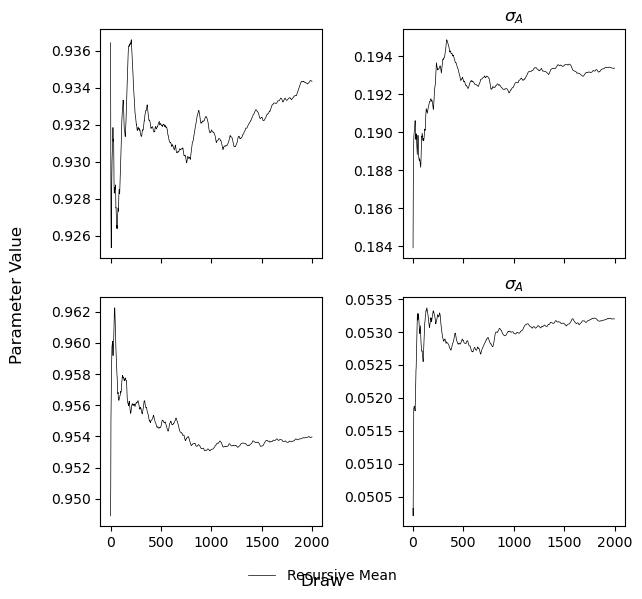

In [9]:
## iteration trace plot
# setup plot
fig, axs = plt.subplots(2, 2, sharex=True)
fig.set_figwidth(6.5)
fig.set_figheight(6)
fig.supxlabel('Draw')
fig.supylabel('Parameter Value')

# plot them all
for i in range(2):
    # plot rho
    ax = axs[i, 0]
    recursive_mean = sim_res[:, i].cumsum() / np.arange(1, 1 + sim_res.shape[0])
    ax.plot(recursive_mean, 'k-', linewidth=0.5)
    shock_labels = ['A', r'\psi', 'g', r'\xi', r'{\tau^P}', r'\eta']

    # plot sigma
    ax = axs[i, 1]
    ax.set_title(r'$\sigma_A$')
    recursive_mean = sim_res[:, 2 + i].cumsum() / np.arange(1, 1 + sim_res.shape[0])
    tln, = ax.plot(recursive_mean, 'k-', linewidth=0.5, label='Recursive Mean')

## make the figure
fig.tight_layout()
# fig.subplots_adjust(bottom=1/10 * 8/7)
fig.legend(loc='lower center', bbox_to_anchor=(0.5, 0), frameon=False, handles=[tln], ncols=2)
# fig.savefig('paper/figures/recursive_means.pdf')

In [10]:
# def historical_decomposition(irfs, data, sigmas=None):

#     ## setup
#     N_z, N_x, T = irfs.shape
#     T_obs = data.shape[0]

#     ## loop over each shock, generate the path
#     shock_paths = np.empty((N_z, T + T_obs - 1))
#     output_paths = np.empty((N_z, N_x, T_obs))
#     for i in range(N_z):
#         ## build the constraint matrix
#         irfmat = np.zeros((T_obs * N_x, T + T_obs - 1))
#         irfmat[np.arange(N_x)[:, None] * T_obs + np.arange(T_obs)[:, None, None], np.arange(T) + np.arange(T_obs)[:, None, None]] = irfs[i, :, ::-1]

#         ## match it
#         shock = np.linalg.lstsq(irfmat, data.T.ravel(), rcond=None)[0]
#         shock_paths[i] = shock
#         output_paths[i] = (irfmat @ shock).reshape((N_z, -1))

#     return shock_paths, output_paths


# estG = estimation_G(G, outputs)
# # get the impulse response functions and standard deviations (used in covarience calcualtion)
# irfs = all_shock_irfs(estG, means[:2])
# shock_paths, output_paths = historical_decomposition(irfs, df[np.where(outputs == 'curlC', 'C', outputs)].values)

In [ ]:
def historical_decomposition(estG, outputs, rhos, data):
    ## setup
    N_z = len(est_G)
    N_x = len(outputs)
    T_obs = data.shape[0]

    ## irfs
    irfs = all_shock_irfs(estG, rhos)
    T = irfs.shape[-1]

    ## contraint matrix for each shock
    irfmat = np.zeros((T_obs * N_x, T_obs * N_z))
    for i in range(N_z):
        zirfmat = np.zeros((T_obs * N_x, T + T_obs - 1))
        zirfmat[np.arange(N_x)[:, None] * T_obs + np.arange(T_obs)[:, None, None], np.arange(T) + np.arange(T_obs)[:, None, None]] = irfs[i, :, ::-1]
        irfmat[:, i * T_obs: (i + 1) * T_obs] = zirfmat[:, T - 1:]
    
    ## get shock paths
    shock_paths = np.linalg.lstsq(irfmat, data.T.ravel(), rcond=None)[0].reshape((N_z, -1))

    ## get variable paths
    series_paths = np.empty((N_z, N_x, T_obs))
    for i in range(N_z):
        series_paths[i] = (irfmat[:, i * T_obs: (i + 1) * T_obs] @ shock_paths[i]).reshape((N_x, -1))

    return shock_paths, series_paths

estG = estimation_G(G, outputs)
# get the impulse response functions and standard deviations (used in covarience calcualtion)
shock_paths, series_paths = historical_decomposition(estG, outputs, means[:2], df[np.where(outputs == 'curlC', 'C', outputs)].values)
shock_paths

TypeError: all_shock_irfs() missing 1 required positional argument: 'T'

In [ ]:
from toolkit.irfs import *  # impulse responses

def sim_shock_path(G, shock_paths, rhos, dxs=None):
    '''
    Simulate aggregates after a shock given paths for the shocks
    '''
    ## setup
    T = next(iter(next(iter(G.values())).values())).shape[0]
    T_obs = next(iter(shock_paths.values())).shape[0]

    ## get irfs
    irfs = all_shock_irfs(G, rhos, T, dxs=dxs)

    ## loop to get all the paths
    decomp_series_paths = {}
    series_paths = {}
    for Z, Xirf in irfs.items():
        decomp_series_paths[Z] = {}

        ## get the path for each series
        for X, irf in Xirf.items():
            all_dX_path = irf[..., None] * shock_paths[Z]  # T by Tobs matrix, each column is an irf to the shock at time T
            dX_path = 1 * all_dX_path[0]  # flatten
            for i in range(1, min(T_obs, T)):
                dX_path[i:] += all_dX_path[i, :-i]

            # store results
            decomp_series_paths[Z][X] = dX_path
            add_or_insert(series_paths, X, dX_path)

    return series_paths, decomp_series_paths

## 
shock_paths2 = {ks.shocks[i]: shock_paths[i] for i in range(2)}
rhos2 = {ks.shocks[i]: res.x[i] for i in range(2)}
check = sim_shock_path(G, shock_paths2, rhos2, dxs=dxs)
check[0].keys()

(300, 216)
(216,)
(300, 216)
(216,)
(300, 216)
(216,)
(300, 216)
(216,)
(300, 216)
(216,)
(300, 216)
(216,)
(300, 216)
(216,)
(300, 216)
(216,)
(300, 501, 5, 216)
(501, 5, 216)
(300, 501, 5, 216)
(501, 5, 216)
(300, 216)
(216,)
(300, 216)
(216,)
(300, 216)
(216,)
(300, 216)
(216,)
(300, 216)
(216,)
(300, 216)
(216,)
(300, 216)
(216,)
(300, 216)
(216,)
(300, 501, 5, 216)
(501, 5, 216)
(300, 501, 5, 216)
(501, 5, 216)


dict_keys(['K', 'Y', 'W', 'R', 'G', 'tau', 'curlK', 'curlC', 'a', 'c'])

In [125]:
check[1]['g']['a']

array([[[-0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [-0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 1.98830553e-02, -1.08737943e-02, -1.89002938e-02, ...,
         -2.07758686e-03, -4.57303178e-05, -2.98156646e-03],
        [ 3.60146817e-02, -1.96959791e-02, -3.42345809e-02, ...,
         -3.76318570e-03, -8.28324829e-05, -5.40058684e-03],
        [ 4.58535514e-02, -2.50767338e-02, -4.35871439e-02, ...,
         -4.79125235e-03, -1.05461532e-04, -6.87597597e-03]],

       [[-0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [-0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 3.88543291e-02, -2.12489467e-02, -3.69338728e-02, ...,
         -4.05990137e-03, -8.93635706e-05, -5.82640

In [103]:
series_paths[0, 0, 1]

-1.226788692621476

In [105]:
check[1]['A']['Y'] - series_paths[0, 0]

array([ 0.00000000e+00, -7.54318808e-04, -1.57857843e-03, -2.33126619e-03,
       -3.02839424e-03, -3.63476318e-03, -4.38675928e-03, -5.02353959e-03,
       -5.61853226e-03, -5.77641554e-03, -5.62334534e-03, -5.45362105e-03,
       -5.39053129e-03, -5.06466161e-03, -4.86078253e-03, -4.68382311e-03,
       -4.88472669e-03, -5.32997267e-03, -5.92367111e-03, -6.44346706e-03,
       -7.49273503e-03, -7.91638905e-03, -8.37733828e-03, -8.79097063e-03,
       -9.34379260e-03, -9.53926593e-03, -9.26077081e-03, -8.92759123e-03,
       -8.34227919e-03, -7.27241689e-03, -6.14434307e-03, -5.44689127e-03,
       -4.72958528e-03, -4.51423289e-03, -4.44118297e-03, -4.86332658e-03,
       -5.59572951e-03, -6.84921361e-03, -8.01496239e-03, -8.83483179e-03,
       -9.42765244e-03, -9.52886814e-03, -9.60167043e-03, -9.71754085e-03,
       -9.83418187e-03, -9.80561328e-03, -9.41635985e-03, -8.73632670e-03,
       -8.32362548e-03, -8.05348914e-03, -6.88808579e-03, -5.71535623e-03,
       -4.44509925e-03, -

In [108]:
df

,t,Y,C,G,B,W,N,pi,I
0,1966-01-01,-1.069601,-0.722097,-0.432497,8.261960,0.894277,-0.812130,-0.210461,-0.200451
1,1966-04-01,-1.221468,-0.482309,-0.333225,7.350332,1.068847,-0.638925,-0.031495,-0.137951
2,1966-07-01,-1.182204,-0.756487,-0.113487,7.449903,1.062781,-0.607705,0.113882,0.019549
3,1966-10-01,-1.166026,-0.784436,-0.056967,7.247932,1.192826,-0.769263,-0.016885,0.077049
4,1967-01-01,-1.097181,-0.786898,0.238262,6.940538,1.785734,-0.877707,-0.432535,-0.070451
...,...,...,...,...,...,...,...,...,...
211,2018-10-01,-2.280897,-2.145095,-0.619524,0.303990,4.315263,-0.540457,-0.418823,-0.757951
212,2019-01-01,-2.260741,-2.399085,-0.563993,-0.001074,5.002289,-0.578974,-0.549297,-0.705451
213,2019-04-01,-2.146218,-2.319519,-0.513077,-0.422644,5.184170,-0.534353,-0.333323,-0.700451
214,2019-07-01,-1.906562,-2.200125,-0.460766,-0.019980,5.731694,-0.512193,-0.531567,-0.705451


In [96]:
check[0].keys()

dict_keys(['K', 'Y', 'W', 'R', 'G', 'tau', 'curlK', 'curlC'])

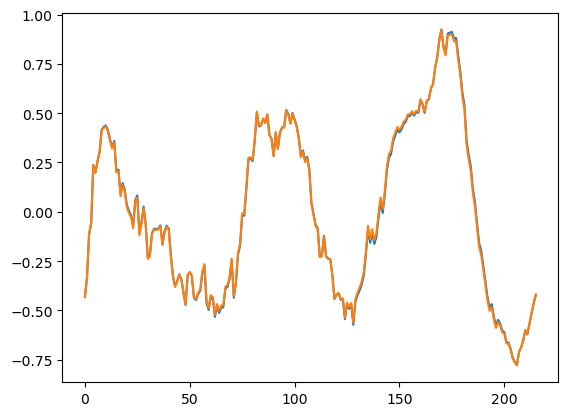

In [109]:
plt.plot(check[0]['G'])
plt.plot(df['G'])

In [56]:
series_paths[0, 0]

array([-1.06960137, -1.22678869, -1.18931482, -1.16964284, -1.09625164,
       -1.35143036, -1.24818028, -1.24051813, -0.66928198, -0.24344837,
       -0.21076462, -0.35115067,  0.02450305, -0.12494477, -0.14850602,
       -0.67146099, -1.03390606, -1.27927212, -1.22105211, -2.01308879,
       -1.20823463, -1.29591673, -1.26655944, -1.49811189, -1.03633333,
       -0.38185467, -0.28529416,  0.0959819 ,  0.82672205,  0.99084831,
        0.46726933,  0.55022944, -0.10476231, -0.28799402, -0.98263199,
       -1.45330508, -2.24734205, -2.21892151, -1.81879605, -1.5614435 ,
       -0.91197359, -0.88171795, -0.95043155, -0.96227981, -0.76705233,
       -0.25499826,  0.18589695, -0.14173632, -0.31234307,  0.97806636,
        1.07845694,  1.30822576,  1.06840249,  0.80420003,  0.79162533,
        0.56188186,  0.37177677, -0.8099939 , -1.1741018 , -0.71342521,
       -0.18308827, -0.77957302, -0.57993768, -1.35524622, -2.29459624,
       -2.37925915, -2.82812927, -3.10678051, -2.82697965, -2.14

In [35]:
np.zeros((2, 3))

array([[0., 0., 0.],
       [0., 0., 0.]])

In [46]:
{Z: single_shock_irfs(G[Z], rhos2[Z], T, sigma=sigma[Z], dxs=dxs, shock=Z)[0] for Z in G.keys()}

{'A': {'K': array([ 7.97201873e-01,  1.48892896e+00,  2.08565818e+00,  2.59693865e+00,
          3.03146593e+00,  3.39715737e+00,  3.70121403e+00,  3.95018811e+00,
          4.15003221e+00,  4.30615202e+00,  4.42345138e+00,  4.50637793e+00,
          4.55896091e+00,  4.58484685e+00,  4.58733252e+00,  4.56939583e+00,
          4.53372349e+00,  4.48273625e+00,  4.41861227e+00,  4.34330886e+00,
          4.25858191e+00,  4.16600434e+00,  4.06698250e+00,  3.96277131e+00,
          3.85448818e+00,  3.74312565e+00,  3.62956307e+00,  3.51457715e+00,
          3.39885176e+00,  3.28298671e+00,  3.16750594e+00,  3.05286485e+00,
          2.93945711e+00,  2.82762078e+00,  2.71764395e+00,  2.60976987e+00,
          2.50420162e+00,  2.40110631e+00,  2.30061897e+00,  2.20284607e+00,
          2.10786864e+00,  2.01574523e+00,  1.92651447e+00,  1.84019745e+00,
          1.75679990e+00,  1.67631408e+00,  1.59872055e+00,  1.52398975e+00,
          1.45208339e+00,  1.38295577e+00,  1.31655491e+00,  1.252

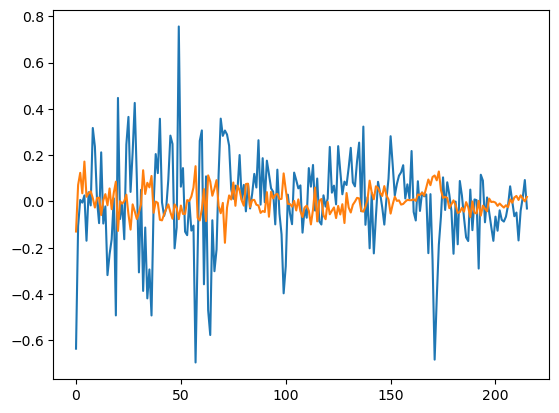

In [20]:
plt.plot(shock_paths.T)

In [21]:
res.x[2:]

array([0.19104364, 0.05277122])

In [22]:
shock_paths[1].var()

0.002802706258173578

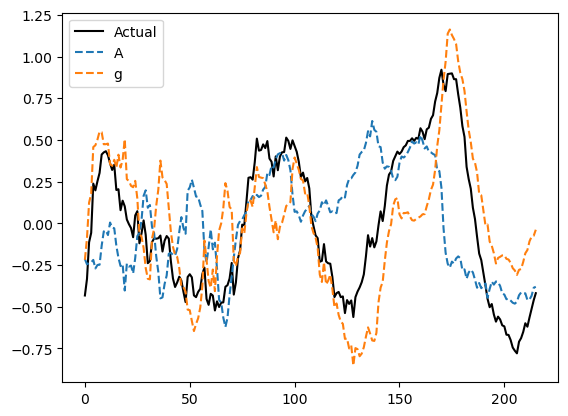

In [23]:
i = 1
plt.plot(df[np.where(outputs == 'curlC', 'C', outputs)[i]], 'k-', label='Actual')
plt.plot(series_paths[:, i].T, '--', label=['A', 'g'])
plt.legend()

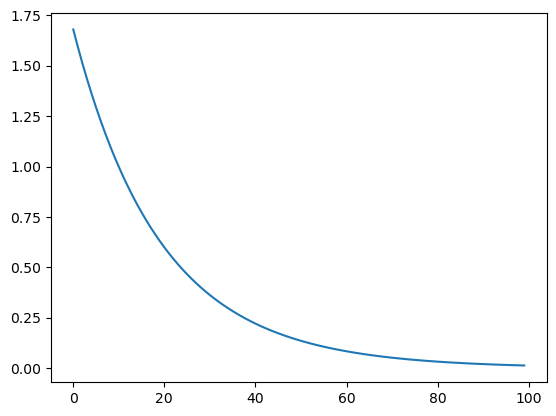

In [24]:
n = 100
plt.plot(irfs[1, 1, :n])